In [1]:
# 10/03/2022 Luís

# In this notebook, in addition to the "train_HGO_diff" notebook,
# the parameters [c, κ, k1, k2, θ] were normalized using sklearn.preprocessing.StandardScaler()
# This way, each of the components of the vector is normaly distributed around 0 with a standard deviation of 1.

# For example, for c, mean = 20.59518917 and std = 12.4038047.
# A original value of 13.78172437 will be transformed into -0.54930442. (z = (x – mean) / std)

# Lower losses were achieved with this normalization.

In [66]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import ast
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd
import random

import sympy as sym
from sympy.physics.quantum import TensorProduct

import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', None)

In [3]:
from sklearn import preprocessing

In [4]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
  plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

### Import data

In [126]:
X = np.load('X_run_10_noise.npy')
y = np.load('y_run_10_noise.npy')

In [127]:
ninc = np.shape(y)[1]

### We will normalize X now

In [128]:
print(X[0])

[13.78172437  0.16673705  0.75092977  5.11546189 35.58234382]


In [129]:
print(np.average(X, axis = 0))

[20.59518917  0.2162714   2.56291629  2.56260512 45.4330007 ]


In [130]:
print(np.std(X, axis = 0))

[12.4038047   0.07358027  1.55743727  1.55886578 27.66829305]


In [131]:
# Normalization of the input data
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [132]:
print(X[0])

[-0.54930442 -0.67320148 -1.1634411   1.63763732 -0.35602691]


### Next we will transform y such that it will contain the differences between its successive elements.

In [8]:
y[0]

array([[ 1.        ,  0.        ],
       [ 1.06666667,  2.78315199],
       [ 1.13333333,  5.60443947],
       [ 1.2       ,  8.48941005],
       [ 1.26666667, 11.4683322 ],
       [ 1.33333333, 14.58647037],
       [ 1.4       , 17.92652069],
       [ 1.46666667, 21.66389753],
       [ 1.53333333, 26.21631173],
       [ 1.6       , 32.68672825]])

In [9]:
np.shape(y)

(100000, 10, 2)

In [113]:
for i in range(len(y)):
    y_diff = np.zeros(np.shape(y[0]))
    for j in range(len(y[0])-1):
        y_diff[j+1] = y[i][j+1]-y[i][j]
    #y_diff[0] = [1,0]
    y[i] = y_diff

y = y[:,1:,:]
    
y[0]

array([[0.06666667, 2.78315199],
       [0.06666667, 2.82128747],
       [0.06666667, 2.88497058],
       [0.06666667, 2.97892216],
       [0.06666667, 3.11813817],
       [0.06666667, 3.34005032],
       [0.06666667, 3.73737684],
       [0.06666667, 4.5524142 ],
       [0.06666667, 6.47041652]])

In [114]:
np.shape(y)

(100000, 9, 2)

### Now we are ready to seperate our data into a training set and a test set

In [11]:
#let's save 10% of the data for testing. these curves won't be part of the model training 
test_split=0.1
x_train, x_test,y_train,y_test = train_test_split(X, y, test_size = test_split)
#let's check the array shapes: 
print('Input data')
print('Training set: ',x_train.shape)
print('Test set: ',x_test.shape)
print(' ')
print('Features')
print('Training set: ',y_train.shape)
print('Test set: ',y_test.shape)
#train_size = train_df.shape[0]
#test_size = test_df.shape[0]

#reshape for keras training
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 2))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 2))
#shuffle data
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]


Input data
Training set:  (90000, 5)
Test set:  (10000, 5)
 
Features
Training set:  (90000, 9, 2)
Test set:  (10000, 9, 2)


In [12]:
np.shape(x_train)

(90000, 5)

In [13]:
np.shape(y_train)

(90000, 9, 2)

### And now we can build our model and train it

In [57]:
# Set the hyperparameters
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 0.001
BATCH_SIZE = 128
EPOCHS = 40
INPUT_SHAPE = x_train.shape[1:]
OUTPUT_SHAPE = y_train.shape[1:]

# Set the model's architechture
inputs = keras.Input(shape=INPUT_SHAPE)

dense = layers.Dense(4 * (ninc-1), activation="relu")
x = dense(inputs)

dense = layers.Dense(8 * (ninc-1), activation="relu")
x = dense(x)

x = tf.keras.layers.Reshape((ninc-1, -1))(x)

dense = layers.Dense(144, activation="relu")
x = dense(x)

dense = layers.Dense(8 * (ninc-1), activation="relu")
x = dense(x)

dropout = tf.keras.layers.Dropout(0.2)
x = dropout(x)

outputs = layers.Dense(2)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="model")


# Compile, defining the loss function, the optimizer and other metrics
model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE, decay = LEARNING_RATE/EPOCHS),
    metrics=["mean_squared_error"],
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_37 (Dense)             (None, 36)                216       
_________________________________________________________________
dense_38 (Dense)             (None, 72)                2664      
_________________________________________________________________
reshape_7 (Reshape)          (None, 9, 8)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 9, 144)            1296      
_________________________________________________________________
dense_40 (Dense)             (None, 9, 72)             10440     
_________________________________________________________________
dropout_8 (Dropout)          (None, 9, 72)             0     

In [58]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history=model.fit(
    x_train,
    y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

Epoch 1/40
563/563 [==============================] - 4s 6ms/step - loss: 3.7209 - mean_squared_error: 30952.3477 - val_loss: 2.7437 - val_mean_squared_error: 17138.8359
Epoch 2/40
563/563 [==============================] - 4s 6ms/step - loss: 2.4925 - mean_squared_error: 26792.9688 - val_loss: 1.5907 - val_mean_squared_error: 11648.3262
Epoch 3/40
563/563 [==============================] - 3s 6ms/step - loss: 1.7109 - mean_squared_error: 19721.7734 - val_loss: 1.1099 - val_mean_squared_error: 7351.9810
Epoch 4/40
563/563 [==============================] - 3s 6ms/step - loss: 1.3245 - mean_squared_error: 14677.5352 - val_loss: 1.0056 - val_mean_squared_error: 5445.6108
Epoch 5/40
563/563 [==============================] - 3s 6ms/step - loss: 1.1138 - mean_squared_error: 11036.4883 - val_loss: 0.7494 - val_mean_squared_error: 3231.3335
Epoch 6/40
563/563 [==============================] - 3s 6ms/step - loss: 0.9935 - mean_squared_error: 9497.3242 - val_loss: 0.7064 - val_mean_squared_er

2.228585332632065


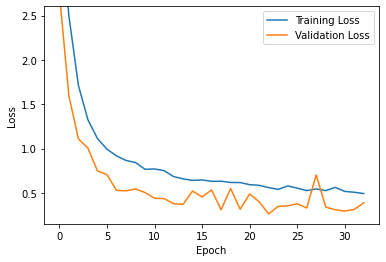

In [59]:
epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [60]:
model.predict(x_test[0:1])[0]

array([[0.06291835, 2.4302256 ],
       [0.06305983, 2.2263725 ],
       [0.06268784, 2.6334167 ],
       [0.06264796, 2.6794453 ],
       [0.0628877 , 2.8734217 ],
       [0.06258792, 3.040851  ],
       [0.06270839, 2.834776  ],
       [0.0627667 , 2.8537157 ],
       [0.06341819, 2.8786287 ]], dtype=float32)

In [61]:
y_test[0:1][0]

array([[0.06666667, 2.63393544],
       [0.06666667, 2.66755198],
       [0.06666667, 2.7290679 ],
       [0.06666667, 2.81408394],
       [0.06666667, 2.92015461],
       [0.06666667, 3.04695852],
       [0.06666667, 3.19673348],
       [0.06666667, 3.37508986],
       [0.06666667, 3.59245875]])

In [89]:
def plot_real_curves(k):
    
    pred_diff = model.predict(x_test[k:k+1])[0]
    pred = np.zeros([np.shape(pred_diff)[0]+1,np.shape(pred_diff)[1]])
    pred[0] = [1,0]
    for i in range(len(pred_diff)):
        pred[i+1] = pred_diff[i] + pred[i]

    plt.plot(pred[:,0],pred[:,1], "--",  color = "r", label = "prediction")

    
    true_dif = y_test[k:k+1][0]
    true = np.zeros([np.shape(true_dif)[0]+1,np.shape(true_dif)[1]])
    true[0] = [1,0]
    for i in range(len(pred_diff)):
        true[i+1] = true_dif[i] + true[i]

    plt.plot(true[:,0],true[:,1], color = "g", label = "real")

    plt.xlabel("λ")
    plt.ylabel("σ")
    plt.legend()
    plt.show()

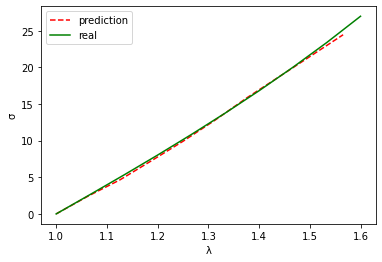

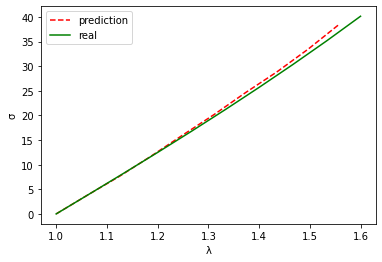

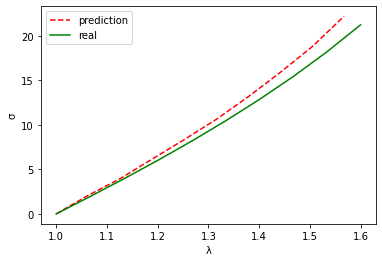

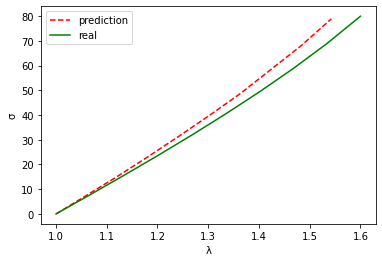

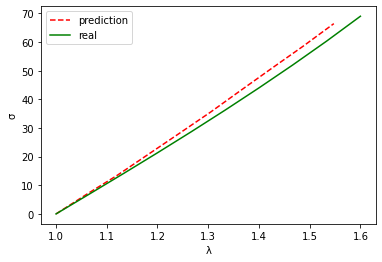

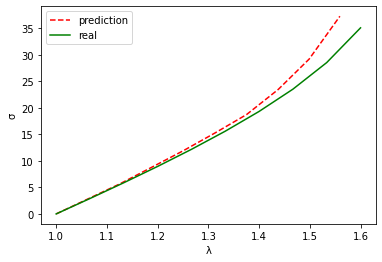

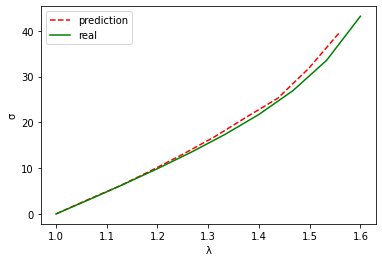

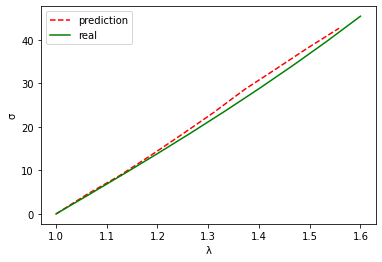

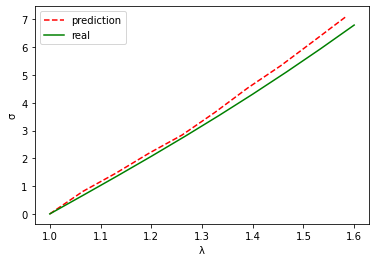

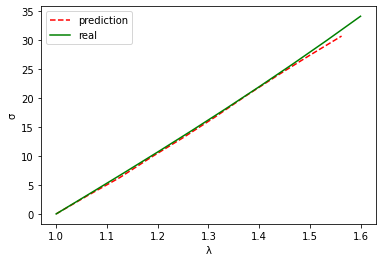

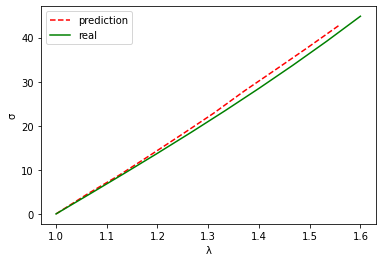

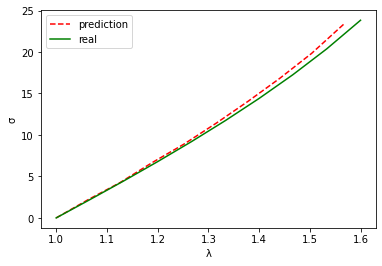

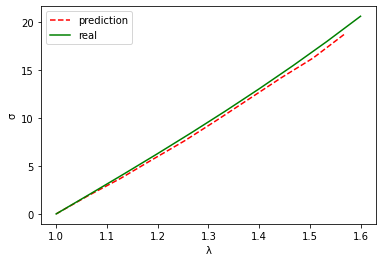

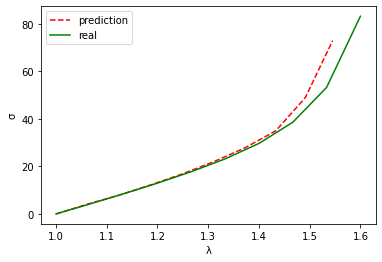

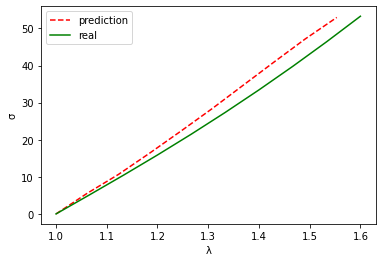

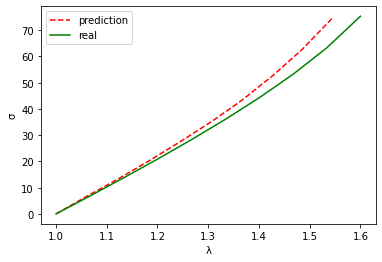

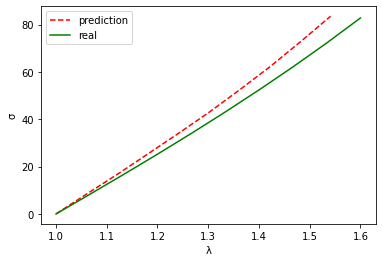

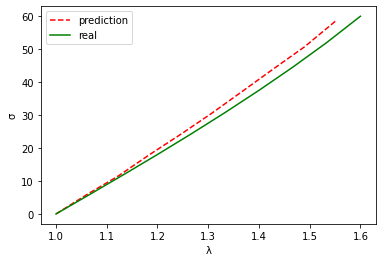

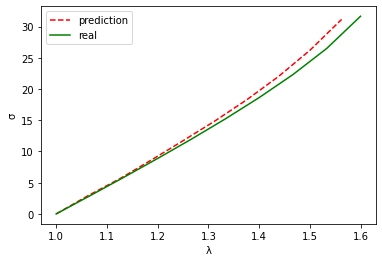

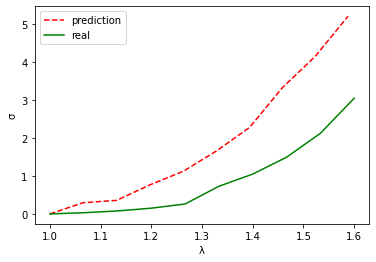

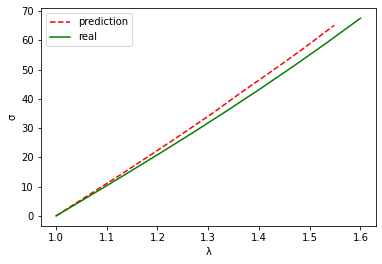

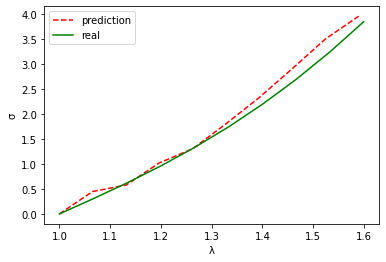

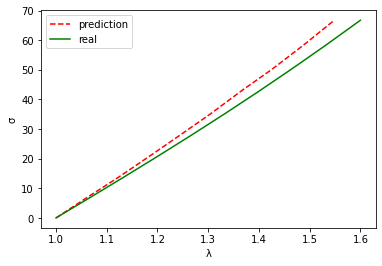

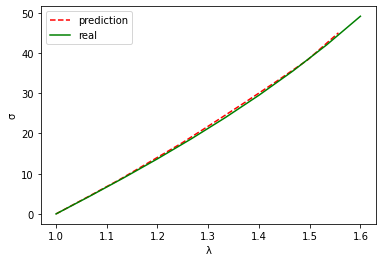

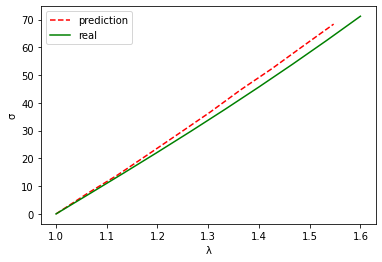

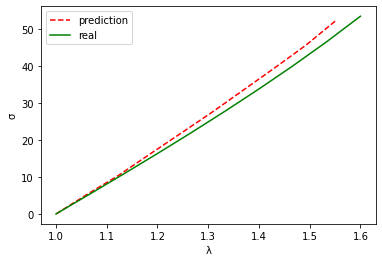

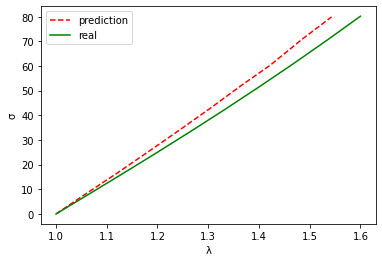

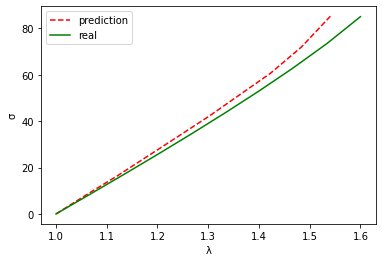

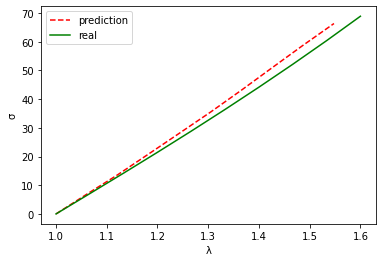

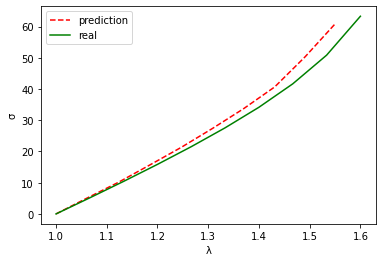

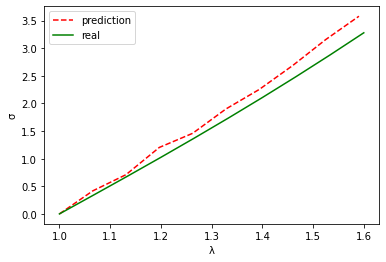

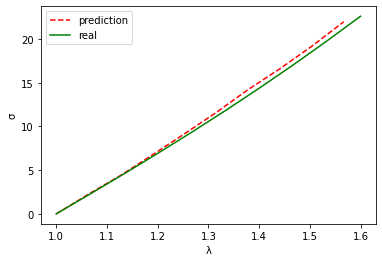

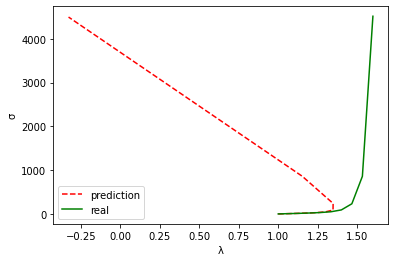

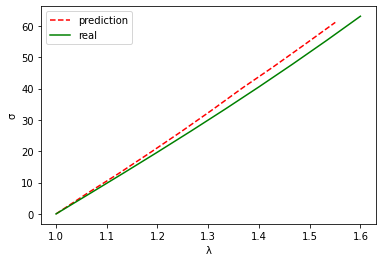

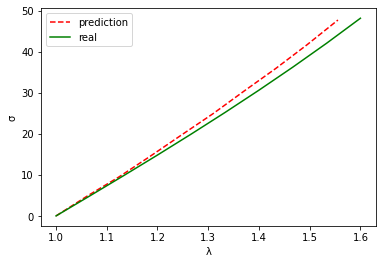

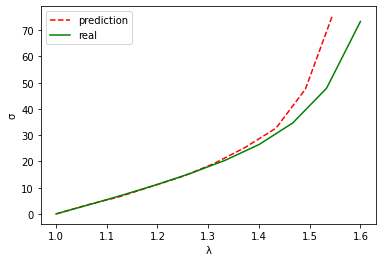

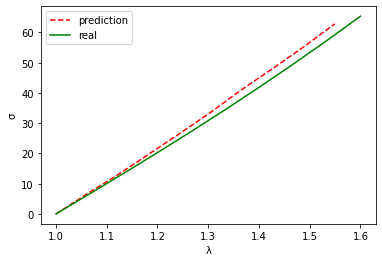

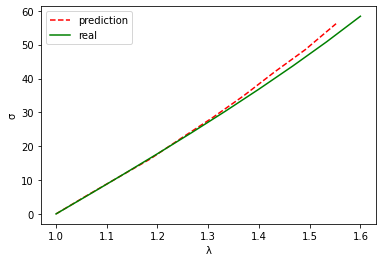

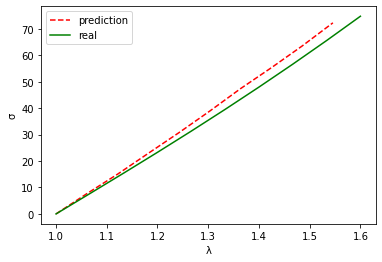

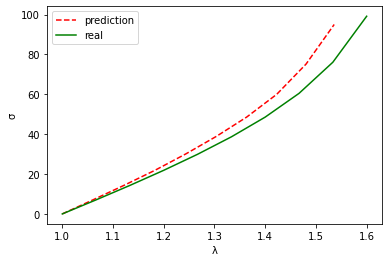

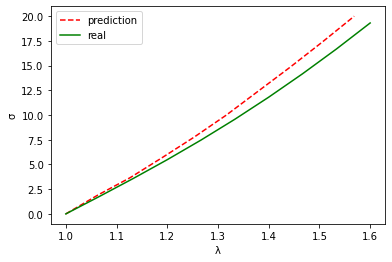

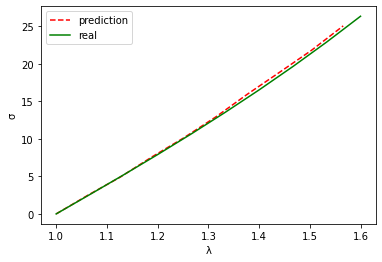

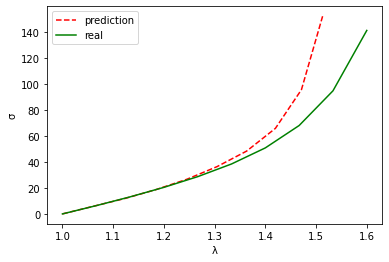

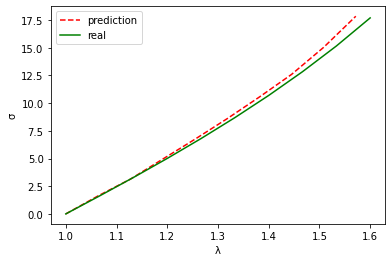

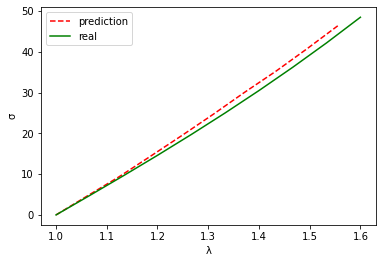

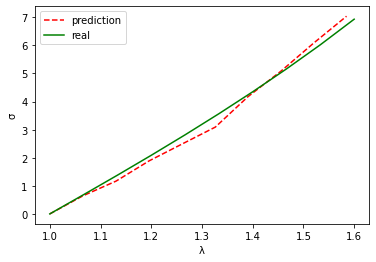

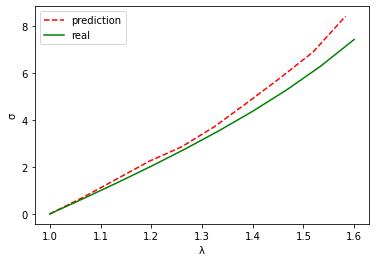

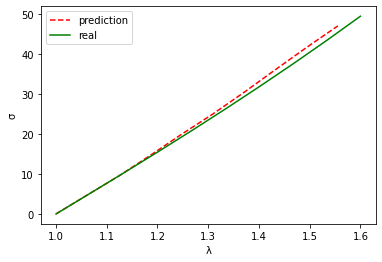

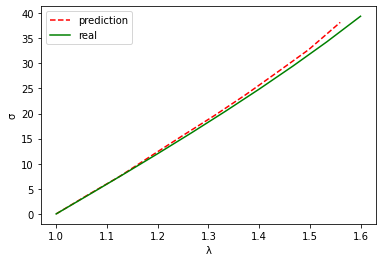

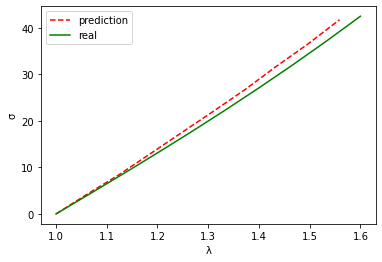

In [90]:
for i in range(50): plot_real_curves(i)

In [91]:
model.predict(x_test[0:1])[0]

array([[0.06291835, 2.4302256 ],
       [0.06305983, 2.2263725 ],
       [0.06268784, 2.6334167 ],
       [0.06264796, 2.6794453 ],
       [0.0628877 , 2.8734217 ],
       [0.06258792, 3.040851  ],
       [0.06270839, 2.834776  ],
       [0.0627667 , 2.8537157 ],
       [0.06341819, 2.8786287 ]], dtype=float32)

In [92]:
y_test[0:1]

array([[[0.06666667, 2.63393544],
        [0.06666667, 2.66755198],
        [0.06666667, 2.7290679 ],
        [0.06666667, 2.81408394],
        [0.06666667, 2.92015461],
        [0.06666667, 3.04695852],
        [0.06666667, 3.19673348],
        [0.06666667, 3.37508986],
        [0.06666667, 3.59245875]]])